In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Parser():
    """
        preprocesses CSV files for time series data
    """
    
    def __init__(self, main_path="data/prices-split-adjusted.csv"):
        self.data = pd.read_csv(main_path)

    def info(self):
        """
            shows overview of each stock
        """
        return self.data.loc[:,["symbol","open"]].groupby("symbol").count()
    
    def getAll(self, limit=1500):
        """
            gets all stocks which have >=limit rows
            
            returns dictionary where
                key = stock symbol
                value = pd.DataFrame containing price info
        """
        
        counts = self.data.loc[:, ["symbol","open"]].groupby("symbol", as_index=False).count()
        counts = {k:v for k,v in counts.values if v >= limit}
        
        return {k: self.get(v) for k,v in counts.items()}
        
        

    
    def get(self, symbol):
        """
            returns only the prices where symbol is input
            price in this case = (high + low) / 2 for simplicity
        """
        out = self.data[self.data["symbol"]==symbol]
        out["price"] = [(high+low)/2 for high,low in zip(out["high"], out["low"])]
        out = out.set_index("date")
        return out.loc[:,["price"]]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


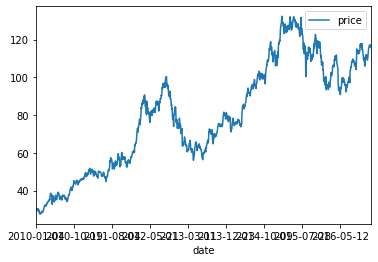

In [3]:
parser = Parser()
apple = parser.get("AAPL")
apple.plot()

In [4]:
# splitting into train and test sets

split = int(apple.shape[0]*0.7)
train, test = apple.iloc[:split, :], apple.iloc[split:, :]

# Autoregression model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


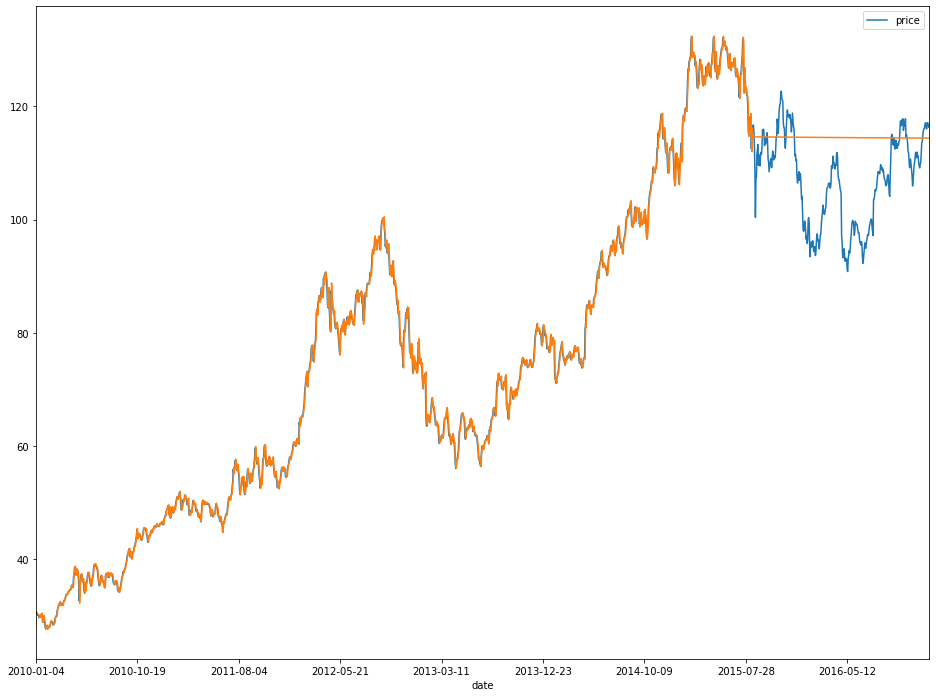

In [5]:
# !pip install statsmodels # on windows
# !pip3 install statsmodels # on mac

from statsmodels.tsa.ar_model import AutoReg

start = int(apple.shape[0]*0.8)

model = AutoReg(apple, lags=5).fit()
pred = model.predict(start=0, dynamic=start)

# pred = pd.Series([0 for i in range(start)]).append(pred)

apple.plot(figsize=(16,12))
pred.plot()


# ARIMA Model

In [6]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(train, order=(1,1,1))
arima_model_fit = arima_model.fit(disp=0)

arima_model_fit.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 1232
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1696.760
Method:                       css-mle   S.D. of innovations              0.959
Date:                Wed, 22 Apr 2020   AIC                           3401.520
Time:                        20:31:24   BIC                           3421.985
Sample:                             1   HQIC                          3409.219
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0709      0.033      2.170      0.030       0.007       0.135
ar.L1.D.price    -0.0360      0.120     -0.301      0.764      -0.270       0.199
ma.L1.D.price     0.2392      0.115      2.073      0.038       0.013       0.465
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -27.8039           +0.0000j           27.8039            0.5000
MA.1           -4.1814           +0.0000j            4.1814            0.5000
-----------------------------------------------------------------------------
"""

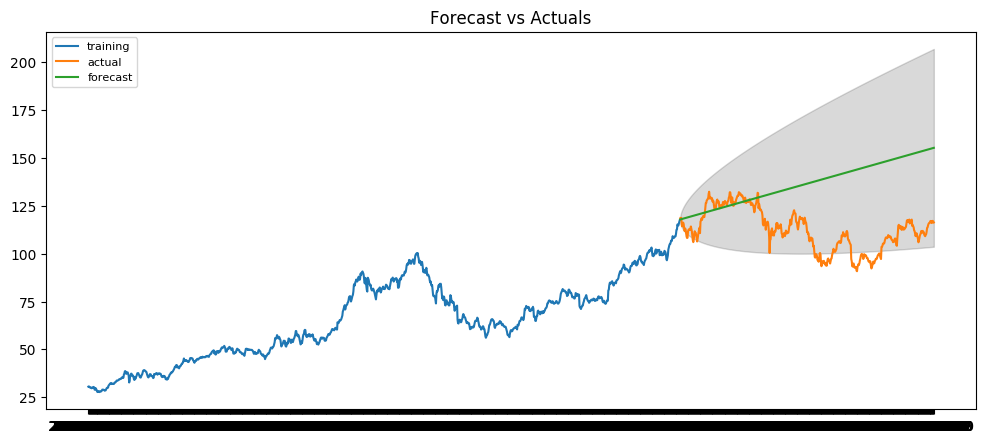

In [7]:
fc, se, conf = arima_model_fit.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Classification
use n last prices to predict whether next price tick will be higher or lower than previous one

In [43]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

WINDOW = 50

x = []
y = []
for i in range(WINDOW, len(apple.values)):
    xv = apple["price"].values[i-WINDOW:i]
    yv = apple["price"].values[i]
    x.append(xv)
    
    if yv < xv[-1]:
        y.append(0)
    else:
        y.append(1)
    
x = pd.DataFrame(x)

Scalers = [
    ("standard scaler", StandardScaler),
    ("min max scaler", MinMaxScaler),
    ("robust scaler", RobustScaler),
    ("max ab scaler", MaxAbsScaler)
]

Models = [
    ("Naive bayes", BernoulliNB),
    ("logistic regresssion", LogisticRegression),
    ("decision tree", DecisionTreeClassifier),
    ("random forest", RandomForestClassifier),
    ("support vector machine", LinearSVC)
]

for scaler_name, Scaler in Scalers:

    print("="*100)
    print("scaler used:", scaler_name)
    print("="*100)
    print()
    
    for model_name, Model in Models:

        scaler = Scaler()
        x_scaled = scaler.fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x_scaled,y)


        model = Model()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        print(f"{model_name} accuracy score:", accuracy_score(y_pred, y_test))
        print(f"{model_name} precision score:", precision_score(y_pred, y_test))
        print(f"{model_name} recall score:", recall_score(y_pred, y_test))
        print(f"{model_name} f1 score:", f1_score(y_pred, y_test))
        print()




scaler used: standard scaler

Naive bayes accuracy score: 0.4392523364485981
Naive bayes precision score: 0.4322033898305085
Naive bayes recall score: 0.49038461538461536
Naive bayes f1 score: 0.4594594594594595

logistic regresssion accuracy score: 0.5654205607476636
logistic regresssion precision score: 0.8529411764705882
logistic regresssion recall score: 0.5734463276836158
logistic regresssion f1 score: 0.6858108108108107

decision tree accuracy score: 0.5070093457943925
decision tree precision score: 0.5854700854700855
decision tree recall score: 0.545816733067729
decision tree f1 score: 0.5649484536082473



/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


random forest accuracy score: 0.5677570093457944
random forest precision score: 0.5983606557377049
random forest recall score: 0.6266094420600858
random forest f1 score: 0.6121593291404612

support vector machine accuracy score: 0.514018691588785
support vector machine precision score: 0.6977777777777778
support vector machine recall score: 0.5286195286195287
support vector machine f1 score: 0.6015325670498084

scaler used: min max scaler

Naive bayes accuracy score: 0.5420560747663551
Naive bayes precision score: 0.9957081545064378
Naive bayes recall score: 0.5433255269320844
Naive bayes f1 score: 0.7030303030303031

logistic regresssion accuracy score: 0.5630841121495327
logistic regresssion precision score: 0.875
logistic regresssion recall score: 0.5817694369973191
logistic regresssion f1 score: 0.6988727858293076



/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


decision tree accuracy score: 0.5373831775700935
decision tree precision score: 0.573170731707317
decision tree recall score: 0.6025641025641025
decision tree f1 score: 0.5874999999999999

random forest accuracy score: 0.5794392523364486
random forest precision score: 0.6382978723404256
random forest recall score: 0.6122448979591837
random forest f1 score: 0.625

support vector machine accuracy score: 0.5373831775700935
support vector machine precision score: 0.8577586206896551
support vector machine recall score: 0.5467032967032966
support vector machine f1 score: 0.6677852348993288

scaler used: robust scaler

Naive bayes accuracy score: 0.5163551401869159
Naive bayes precision score: 0.5263157894736842
Naive bayes recall score: 0.547945205479452
Naive bayes f1 score: 0.5369127516778524



/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


logistic regresssion accuracy score: 0.5397196261682243
logistic regresssion precision score: 0.7831325301204819
logistic regresssion recall score: 0.5769230769230769
logistic regresssion f1 score: 0.6643952299829642

decision tree accuracy score: 0.5771028037383178
decision tree precision score: 0.6188524590163934
decision tree recall score: 0.6317991631799164
decision tree f1 score: 0.6252587991718427

random forest accuracy score: 0.6121495327102804
random forest precision score: 0.6408163265306123
random forest recall score: 0.6680851063829787
random forest f1 score: 0.6541666666666668

support vector machine accuracy score: 0.5163551401869159
support vector machine precision score: 0.7555555555555555
support vector machine recall score: 0.5279503105590062
support vector machine f1 score: 0.6215722120658135

scaler used: max ab scaler

Naive bayes accuracy score: 0.5420560747663551
Naive bayes precision score: 1.0
Naive bayes recall score: 0.5420560747663551
Naive bayes f1 score: 0

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


decision tree accuracy score: 0.5373831775700935
decision tree precision score: 0.5793991416309013
decision tree recall score: 0.574468085106383
decision tree f1 score: 0.5769230769230769

random forest accuracy score: 0.5771028037383178
random forest precision score: 0.6696428571428571
random forest recall score: 0.5836575875486382
random forest f1 score: 0.6237006237006237

support vector machine accuracy score: 0.5257009345794392
support vector machine precision score: 0.7676348547717843
support vector machine recall score: 0.5572289156626506
support vector machine f1 score: 0.6457242582897034

